In [ ]:
!pip install torch pyro-ppl
!pip install yfinance
!pip install mplfinance
!pip install statsmodels

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroSample
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import mplfinance as mpf
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm

torch.manual_seed(42)
np.random.seed(42)

In [ ]:
ticker = "GC=F"

data = yf.download(ticker, start="2010-01-01", end="2024-12-31")

data.to_csv("Gold_historical_data.csv")

/tmp/ipython-input-40-844112362.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2010-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


In [ ]:
df = pd.read_csv('Gold_historical_data.csv')
df

,Price,Close,High,Low,Open,Volume
0,Ticker,GC=F,GC=F,GC=F,GC=F,GC=F
1,Date,NaN,NaN,NaN,NaN,NaN
2,2010-01-04,1117.699951171875,1122.300048828125,1097.0999755859375,1117.699951171875,184
3,2010-01-05,1118.0999755859375,1126.5,1115.0,1118.0999755859375,53
4,2010-01-06,1135.9000244140625,1139.199951171875,1120.699951171875,1135.9000244140625,363
...,...,...,...,...,...,...
3767,2024-12-23,2612.300048828125,2627.699951171875,2611.10009765625,2620.0,451
3768,2024-12-24,2620.0,2620.0,2609.5,2613.0,35
3769,2024-12-26,2638.800048828125,2638.800048828125,2627.89990234375,2628.5,84
3770,2024-12-27,2617.199951171875,2617.699951171875,2616.39990234375,2617.699951171875,642


In [ ]:
import pandas as pd
df = df.iloc[2:].copy()
df.rename(columns={'Price': 'Date'}, inplace=True)
df['Date'] = pd.to_datetime(df['Date'])


In [ ]:
df

,Date,Close,High,Low,Open,Volume
2,2010-01-04,1117.699951171875,1122.300048828125,1097.0999755859375,1117.699951171875,184
3,2010-01-05,1118.0999755859375,1126.5,1115.0,1118.0999755859375,53
4,2010-01-06,1135.9000244140625,1139.199951171875,1120.699951171875,1135.9000244140625,363
5,2010-01-07,1133.0999755859375,1133.0999755859375,1129.199951171875,1133.0999755859375,56
6,2010-01-08,1138.199951171875,1138.199951171875,1122.699951171875,1138.199951171875,54
...,...,...,...,...,...,...
3767,2024-12-23,2612.300048828125,2627.699951171875,2611.10009765625,2620.0,451
3768,2024-12-24,2620.0,2620.0,2609.5,2613.0,35
3769,2024-12-26,2638.800048828125,2638.800048828125,2627.89990234375,2628.5,84
3770,2024-12-27,2617.199951171875,2617.699951171875,2616.39990234375,2617.699951171875,642


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 2 to 3771
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3770 non-null   datetime64[ns]
 1   Close   3770 non-null   object        
 2   High    3770 non-null   object        
 3   Low     3770 non-null   object        
 4   Open    3770 non-null   object        
 5   Volume  3770 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 176.8+ KB


In [ ]:
df['Month'] = df['Date'].dt.month
df['WeekOfYear'] = df['Date'].dt.isocalendar().week


In [ ]:
for col in df.columns:
  if col != 'Date':
    df[col] = pd.to_numeric(df[col], errors='coerce')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3770 entries, 2 to 3771
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        3770 non-null   datetime64[ns]
 1   Close       3770 non-null   float64       
 2   High        3770 non-null   float64       
 3   Low         3770 non-null   float64       
 4   Open        3770 non-null   float64       
 5   Volume      3770 non-null   int64         
 6   Month       3770 non-null   int32         
 7   WeekOfYear  3770 non-null   UInt32        
dtypes: UInt32(1), datetime64[ns](1), float64(4), int32(1), int64(1)
memory usage: 210.0 KB


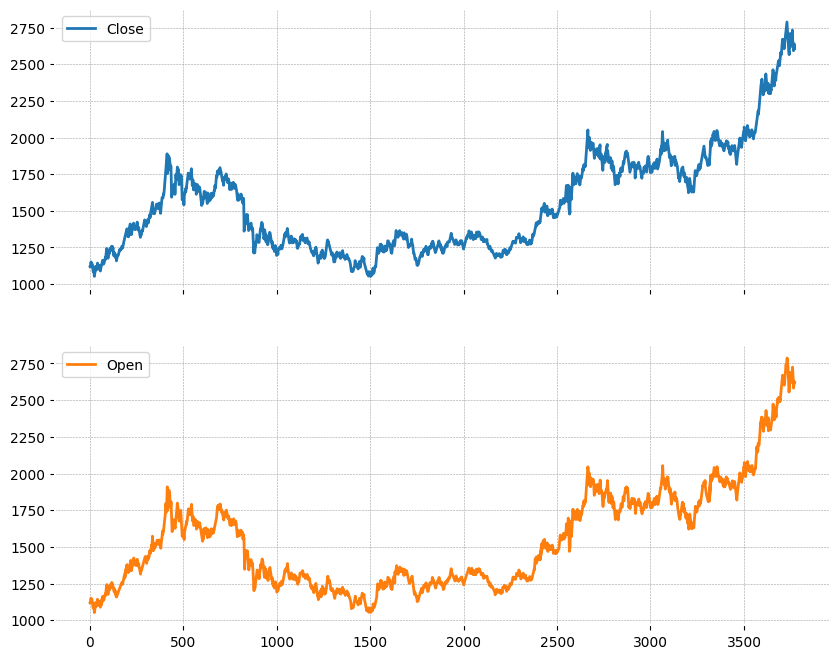

In [ ]:
df[['Close', 'Open']].plot(subplots=True, figsize=(10, 8))
plt.show()

In [ ]:
df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184,1,1
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53,1,1
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363,1,1
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56,1,1
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54,1,1
...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52


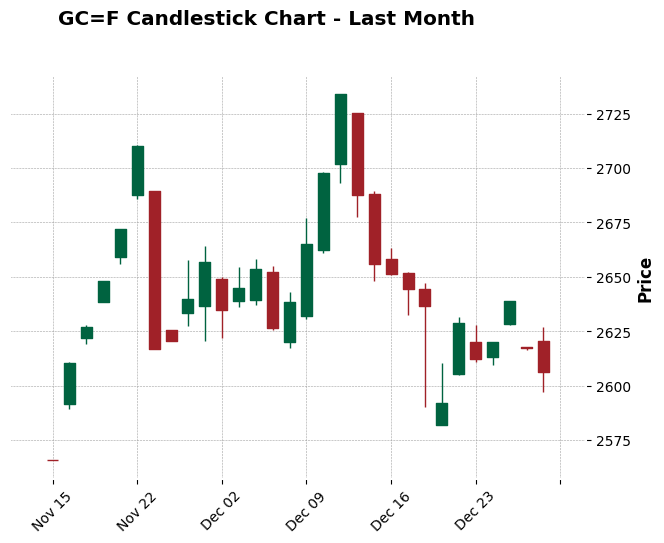

In [ ]:
df_year = df.iloc[-30:].copy()
df_year['Date'] = pd.to_datetime(df_year['Date'])
df_year.set_index('Date', inplace=True)
df_year.dropna(inplace=True)
mpf.plot(df_year, type='candle', style='charles', title=f'{ticker} Candlestick Chart - Last Month')

In [ ]:
df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184,1,1
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53,1,1
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363,1,1
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56,1,1
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54,1,1
...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52


In [ ]:
df['Day'] = df['Date'].dt.day_name()
df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Day
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184,1,1,Monday
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53,1,1,Tuesday
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363,1,1,Wednesday
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56,1,1,Thursday
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54,1,1,Friday
...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,Monday
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,Tuesday
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,Thursday
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52,Friday


In [ ]:
df['Close_Pct_Change'] = df['Close'].pct_change()
df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Day,Close_Pct_Change
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184,1,1,Monday,NaN
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53,1,1,Tuesday,0.000358
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363,1,1,Wednesday,0.015920
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56,1,1,Thursday,-0.002465
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54,1,1,Friday,0.004501
...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,Monday,-0.006239
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,Tuesday,0.002948
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,Thursday,0.007176
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52,Friday,-0.008186


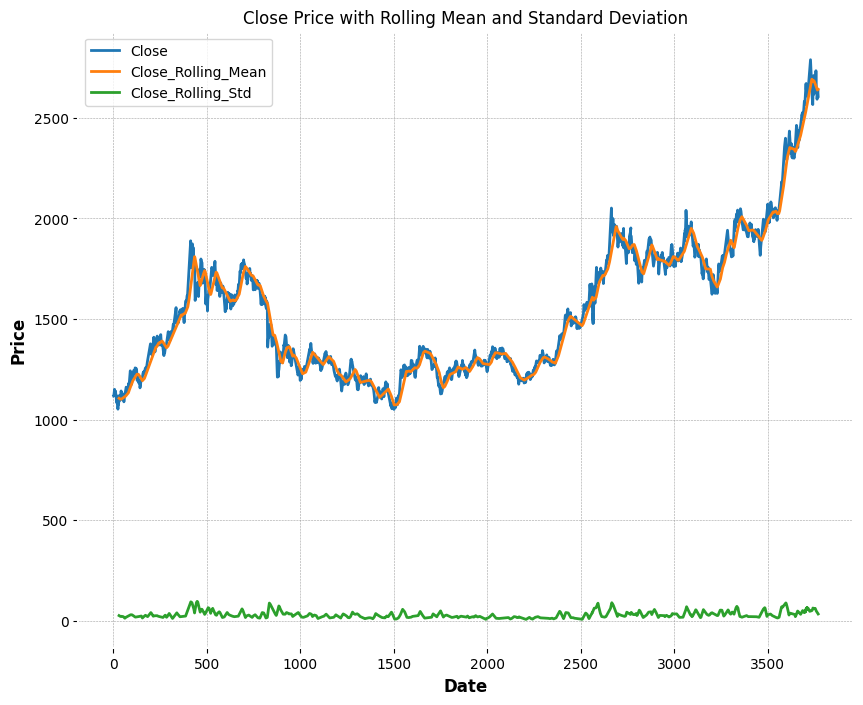

In [ ]:
window_size = 30
df['Close_Rolling_Mean'] = df['Close'].rolling(window=window_size).mean()
df['Close_Rolling_Std'] = df['Close'].rolling(window=window_size).std()
df[['Close', 'Close_Rolling_Mean', 'Close_Rolling_Std']].plot(figsize=(10, 8))
plt.title('Close Price with Rolling Mean and Standard Deviation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
def calculate_rsi(data, window):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

rsi_lengths = [2,7,14,30,60,90,120,150]

for length in rsi_lengths:
    df[f'RSI_{length}'] = calculate_rsi(df['Close'], length)

df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Day,Close_Pct_Change,Close_Rolling_Mean,Close_Rolling_Std,RSI_2,RSI_7,RSI_14,RSI_30,RSI_60,RSI_90,RSI_120,RSI_150
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184,1,1,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53,1,1,Tuesday,0.000358,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363,1,1,Wednesday,0.015920,NaN,NaN,100.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56,1,1,Thursday,-0.002465,NaN,NaN,86.407594,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54,1,1,Friday,0.004501,NaN,NaN,64.556453,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,Monday,-0.006239,2637.723332,38.816100,68.998237,24.628888,45.207115,45.111807,48.790810,54.408507,55.298167,52.963852
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,Tuesday,0.002948,2638.016667,38.641609,31.950199,35.530535,44.979194,50.628037,49.391393,53.433645,54.900717,53.299392
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,Thursday,0.007176,2639.310002,37.968775,100.000000,45.454593,51.858616,52.739343,48.912463,53.840979,56.040729,54.171961
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52,Friday,-0.008186,2640.523332,36.591163,46.534606,41.122729,46.832424,52.561209,48.860252,52.949037,55.437586,54.768824


In [ ]:
def calculate_ma(data, window):
    return data.rolling(window=window).mean()

def calculate_ema(data, window):
    return data.ewm(span=window, adjust=False).mean()

ma_lengths = [7,14,30,60,90,120,180]
ema_lengths = [7,14,30,60,90,120,180]

for length in ma_lengths:
    df[f'MA_{length}'] = calculate_ma(df['Close'], length)

for length in ema_lengths:
    df[f'EMA_{length}'] = calculate_ema(df['Close'], length)

df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Day,Close_Pct_Change,...,MA_90,MA_120,MA_180,EMA_7,EMA_14,EMA_30,EMA_60,EMA_90,EMA_120,EMA_180
2,2010-01-04,1117.699951,1122.300049,1097.099976,1117.699951,184,1,1,Monday,NaN,...,NaN,NaN,NaN,1117.699951,1117.699951,1117.699951,1117.699951,1117.699951,1117.699951,1117.699951
3,2010-01-05,1118.099976,1126.500000,1115.000000,1118.099976,53,1,1,Tuesday,0.000358,...,NaN,NaN,NaN,1117.799957,1117.753288,1117.725759,1117.713067,1117.708743,1117.706563,1117.704371
4,2010-01-06,1135.900024,1139.199951,1120.699951,1135.900024,363,1,1,Wednesday,0.015920,...,NaN,NaN,NaN,1122.324974,1120.172853,1118.898292,1118.309360,1118.108551,1118.007282,1117.905428
5,2010-01-07,1133.099976,1133.099976,1129.199951,1133.099976,56,1,1,Thursday,-0.002465,...,NaN,NaN,NaN,1125.018724,1121.896469,1119.814530,1118.794299,1118.438033,1118.256748,1118.073324
6,2010-01-08,1138.199951,1138.199951,1122.699951,1138.199951,54,1,1,Friday,0.004501,...,NaN,NaN,NaN,1128.314031,1124.070267,1121.000686,1119.430550,1118.872361,1118.586387,1118.295717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,Monday,-0.006239,...,2625.155553,2571.874164,2495.008884,2630.964770,2641.636027,2648.537227,2634.909743,2603.444209,2566.692804,2493.533653
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,Tuesday,0.002948,...,2626.504441,2573.803330,2496.544995,2628.223577,2638.751224,2646.696116,2634.420899,2603.808072,2567.573915,2494.931071
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,Thursday,0.007176,...,2628.026663,2576.166665,2498.262773,2630.867695,2638.757734,2646.186692,2634.564477,2604.577127,2568.751207,2496.520783
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52,Friday,-0.008186,...,2629.203328,2578.309163,2499.720550,2627.450759,2635.883363,2644.316580,2633.995149,2604.854551,2569.552012,2497.854255


In [ ]:
def calc_fib_levels(df, window=30):
    fib_ratios = [0.236, 0.382, 0.5, 0.618, 0.786]
    levels = pd.DataFrame(index=df.index)

    highs = df['High'].rolling(window=window)
    lows = df['Low'].rolling(window=window)

    for ratio in fib_ratios:
        levels[f'Fib_{int(ratio*100)}'] = highs.max() - (highs.max() - lows.min()) * ratio

    return levels
fib_levels = calc_fib_levels(df, window=30)
df = pd.concat([df, fib_levels], axis=1)
df = df.dropna()

In [ ]:
df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Day,Close_Pct_Change,...,EMA_30,EMA_60,EMA_90,EMA_120,EMA_180,Fib_23,Fib_38,Fib_50,Fib_61,Fib_78
181,2010-09-20,1279.000000,1282.000000,1279.000000,1279.000000,27,9,38,Monday,0.002665,...,1243.036931,1226.994567,1214.986017,1204.588190,1188.278353,1260.524000,1247.238000,1236.500000,1225.762000,1210.474000
182,2010-09-21,1272.400024,1289.800049,1271.800049,1272.400024,56,9,38,Tuesday,-0.005160,...,1244.931325,1228.483271,1216.247864,1205.709047,1189.207874,1266.483237,1252.058430,1240.400024,1228.741619,1212.143210
183,2010-09-22,1290.199951,1290.199951,1290.199951,1290.199951,17,9,38,Wednesday,0.013989,...,1247.851881,1230.506769,1217.873184,1207.105591,1190.323809,1267.260763,1253.069570,1241.599976,1230.130381,1213.800790
184,2010-09-23,1294.300049,1294.300049,1289.400024,1294.300049,45,9,38,Thursday,0.003178,...,1250.848537,1232.598352,1219.552896,1208.546822,1191.472717,1271.809237,1257.895430,1246.650024,1235.404619,1219.394210
185,2010-09-24,1296.000000,1297.400024,1294.199951,1296.000000,37,9,38,Friday,0.001313,...,1253.761535,1234.677094,1221.233052,1209.992329,1192.627715,1277.127619,1264.586215,1254.450012,1244.313809,1229.882605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,Monday,-0.006239,...,2648.537227,2634.909743,2603.444209,2566.692804,2493.533653,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,Tuesday,0.002948,...,2646.696116,2634.420899,2603.808072,2567.573915,2494.931071,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,Thursday,0.007176,...,2646.186692,2634.564477,2604.577127,2568.751207,2496.520783,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52,Friday,-0.008186,...,2644.316580,2633.995149,2604.854551,2569.552012,2497.854255,2691.414426,2665.192812,2644.000000,2622.807188,2592.634372


In [ ]:
for lag in [30]:
    df[f'Close_Lag_{lag}'] = df['Close'].shift(lag)

df['Daily_Return'] = df['Close'].pct_change()
df['Volatility_7D'] = df['Daily_Return'].rolling(7).std()
df['Volatility_30D'] = df['Daily_Return'].rolling(30).std()


In [ ]:
encoder = OneHotEncoder(sparse_output=False)

day_reshaped = df['Day'].values.reshape(-1, 1)

day_encoded = encoder.fit_transform(day_reshaped)
day_encoded_df = pd.DataFrame(day_encoded, columns=encoder.get_feature_names_out(['Day']), index=df.index)

df = pd.concat([df, day_encoded_df], axis=1)

df.drop('Day', axis=1, inplace=True)

df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Close_Pct_Change,Close_Rolling_Mean,...,Fib_78,Close_Lag_30,Daily_Return,Volatility_7D,Volatility_30D,Day_Friday,Day_Monday,Day_Thursday,Day_Tuesday,Day_Wednesday
181,2010-09-20,1279.000000,1282.000000,1279.000000,1279.000000,27,9,38,0.002665,1239.406665,...,1210.474000,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0
182,2010-09-21,1272.400024,1289.800049,1271.800049,1272.400024,56,9,38,-0.005160,1241.796667,...,1212.143210,NaN,-0.005160,NaN,NaN,0.0,0.0,0.0,1.0,0.0
183,2010-09-22,1290.199951,1290.199951,1290.199951,1290.199951,17,9,38,0.013989,1244.930001,...,1213.800790,NaN,0.013989,NaN,NaN,0.0,0.0,0.0,0.0,1.0
184,2010-09-23,1294.300049,1294.300049,1289.400024,1294.300049,45,9,38,0.003178,1248.156669,...,1219.394210,NaN,0.003178,NaN,NaN,0.0,0.0,1.0,0.0,0.0
185,2010-09-24,1296.000000,1297.400024,1294.199951,1296.000000,37,9,38,0.001313,1250.863334,...,1229.882605,NaN,0.001313,NaN,NaN,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,-0.006239,2637.723332,...,2592.634372,2687.500000,-0.006239,0.009691,0.012411,0.0,1.0,0.0,0.0,0.0
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,0.002948,2638.016667,...,2592.634372,2611.199951,0.002948,0.009323,0.011282,0.0,0.0,0.0,1.0,0.0
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,0.007176,2639.310002,...,2592.634372,2600.000000,0.007176,0.009939,0.011320,0.0,0.0,1.0,0.0,0.0
3770,2024-12-27,2617.199951,2617.699951,2616.399902,2617.699951,642,12,52,-0.008186,2640.523332,...,2592.634372,2580.800049,-0.008186,0.010338,0.011340,1.0,0.0,0.0,0.0,0.0


In [ ]:
df.columns

Index(['Date', 'Close', 'High', 'Low', 'Open', 'Volume', 'Month', 'WeekOfYear',
       'Close_Pct_Change', 'Close_Rolling_Mean', 'Close_Rolling_Std', 'RSI_2',
       'RSI_7', 'RSI_14', 'RSI_30', 'RSI_60', 'RSI_90', 'RSI_120', 'RSI_150',
       'MA_7', 'MA_14', 'MA_30', 'MA_60', 'MA_90', 'MA_120', 'MA_180', 'EMA_7',
       'EMA_14', 'EMA_30', 'EMA_60', 'EMA_90', 'EMA_120', 'EMA_180', 'Fib_23',
       'Fib_38', 'Fib_50', 'Fib_61', 'Fib_78', 'Close_Lag_30', 'Daily_Return',
       'Volatility_7D', 'Volatility_30D', 'Day_Friday', 'Day_Monday',
       'Day_Thursday', 'Day_Tuesday', 'Day_Wednesday'],
      dtype='object')

In [ ]:
df['Target'] = df['Close'].shift(-1)
df = df.dropna()

feature_columns = ['Close', 'RSI_30', 'MA_30', 'EMA_30',
                  'Close_Rolling_Mean', 'Close_Rolling_Std',
                   'Volatility_30D','Close_Lag_30'] +  \
                 list(day_encoded_df.columns)
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(df[feature_columns])
scaled_target = MinMaxScaler().fit_transform(df[['Target']])

def create_sequences(features, target, sequence_length=30):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(target[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30
X, y = create_sequences(scaled_features, scaled_target, sequence_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
class GoldPriceDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), \
               torch.tensor(self.targets[idx], dtype=torch.float32)

train_dataset = GoldPriceDataset(X_train, y_train)
test_dataset = GoldPriceDataset(X_test, y_test)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
class GoldPricePredictor(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GoldPricePredictor, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = len(feature_columns)
hidden_size = 128
num_layers = 2
output_size = 1

model = GoldPricePredictor(input_size, hidden_size, num_layers, output_size)
print(model)

GoldPricePredictor(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

num_epochs = 50
train_losses = []
test_losses = []

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/50: 100%|██████████| 45/45 [00:08<00:00,  5.42it/s, loss=0.0566]


Epoch 1/50, Train Loss: 0.023829, Test Loss: 0.073620


Epoch 2/50: 100%|██████████| 45/45 [00:07<00:00,  6.20it/s, loss=0.0952]


Epoch 2/50, Train Loss: 0.022863, Test Loss: 0.139360


Epoch 3/50: 100%|██████████| 45/45 [00:06<00:00,  6.44it/s, loss=0.0962]


Epoch 3/50, Train Loss: 0.025271, Test Loss: 0.137161


Epoch 4/50: 100%|██████████| 45/45 [00:06<00:00,  6.85it/s, loss=0.0765]


Epoch 4/50, Train Loss: 0.021416, Test Loss: 0.097294


Epoch 5/50: 100%|██████████| 45/45 [00:08<00:00,  5.40it/s, loss=0.0353]


Epoch 5/50, Train Loss: 0.013862, Test Loss: 0.035366


Epoch 6/50: 100%|██████████| 45/45 [00:05<00:00,  8.26it/s, loss=0.0165]


Epoch 6/50, Train Loss: 0.008374, Test Loss: 0.019934


Epoch 7/50: 100%|██████████| 45/45 [00:03<00:00, 11.97it/s, loss=0.00918]


Epoch 7/50, Train Loss: 0.005052, Test Loss: 0.015527


Epoch 8/50: 100%|██████████| 45/45 [00:03<00:00, 11.93it/s, loss=0.00539]


Epoch 8/50, Train Loss: 0.003380, Test Loss: 0.010696


Epoch 9/50: 100%|██████████| 45/45 [00:04<00:00, 10.28it/s, loss=0.00362]


Epoch 9/50, Train Loss: 0.002567, Test Loss: 0.007395


Epoch 10/50: 100%|██████████| 45/45 [00:03<00:00, 12.31it/s, loss=0.00259]


Epoch 10/50, Train Loss: 0.002147, Test Loss: 0.005257


Epoch 11/50: 100%|██████████| 45/45 [00:03<00:00, 12.99it/s, loss=0.00201]


Epoch 11/50, Train Loss: 0.001934, Test Loss: 0.003913


Epoch 12/50: 100%|██████████| 45/45 [00:03<00:00, 11.56it/s, loss=0.00165]


Epoch 12/50, Train Loss: 0.001836, Test Loss: 0.003035


Epoch 13/50: 100%|██████████| 45/45 [00:03<00:00, 11.92it/s, loss=0.00142]


Epoch 13/50, Train Loss: 0.001800, Test Loss: 0.002436


Epoch 14/50: 100%|██████████| 45/45 [00:03<00:00, 12.92it/s, loss=0.00125]


Epoch 14/50, Train Loss: 0.001793, Test Loss: 0.002015


Epoch 15/50: 100%|██████████| 45/45 [00:03<00:00, 11.50it/s, loss=0.00112]


Epoch 15/50, Train Loss: 0.001790, Test Loss: 0.001718


Epoch 16/50: 100%|██████████| 45/45 [00:03<00:00, 11.31it/s, loss=0.00101]


Epoch 16/50, Train Loss: 0.001777, Test Loss: 0.001516


Epoch 17/50: 100%|██████████| 45/45 [00:03<00:00, 12.85it/s, loss=0.000917]


Epoch 17/50, Train Loss: 0.001746, Test Loss: 0.001390


Epoch 18/50: 100%|██████████| 45/45 [00:03<00:00, 12.53it/s, loss=0.000831]


Epoch 18/50, Train Loss: 0.001698, Test Loss: 0.001327


Epoch 19/50: 100%|██████████| 45/45 [00:04<00:00, 11.15it/s, loss=0.000755]


Epoch 19/50, Train Loss: 0.001635, Test Loss: 0.001319


Epoch 20/50: 100%|██████████| 45/45 [00:03<00:00, 12.21it/s, loss=0.00069]


Epoch 20/50, Train Loss: 0.001564, Test Loss: 0.001354


Epoch 21/50: 100%|██████████| 45/45 [00:03<00:00, 11.61it/s, loss=0.000635]


Epoch 21/50, Train Loss: 0.001490, Test Loss: 0.001424


Epoch 22/50: 100%|██████████| 45/45 [00:05<00:00,  7.70it/s, loss=0.000591]


Epoch 22/50, Train Loss: 0.001418, Test Loss: 0.001519


Epoch 23/50: 100%|██████████| 45/45 [00:03<00:00, 12.98it/s, loss=0.000554]


Epoch 23/50, Train Loss: 0.001352, Test Loss: 0.001631


Epoch 24/50: 100%|██████████| 45/45 [00:04<00:00, 10.58it/s, loss=0.000525]


Epoch 24/50, Train Loss: 0.001293, Test Loss: 0.001755


Epoch 25/50: 100%|██████████| 45/45 [00:03<00:00, 11.97it/s, loss=0.000502]


Epoch 25/50, Train Loss: 0.001243, Test Loss: 0.001885


Epoch 26/50: 100%|██████████| 45/45 [00:03<00:00, 12.18it/s, loss=0.00105]


Epoch 26/50, Train Loss: 0.000818, Test Loss: 0.000695


Epoch 27/50: 100%|██████████| 45/45 [00:04<00:00, 10.01it/s, loss=0.00114]


Epoch 27/50, Train Loss: 0.000409, Test Loss: 0.000485


Epoch 28/50: 100%|██████████| 45/45 [00:03<00:00, 11.71it/s, loss=0.00113]


Epoch 28/50, Train Loss: 0.000352, Test Loss: 0.000478


Epoch 29/50: 100%|██████████| 45/45 [00:03<00:00, 12.19it/s, loss=0.00117]


Epoch 29/50, Train Loss: 0.000315, Test Loss: 0.000470


Epoch 30/50: 100%|██████████| 45/45 [00:04<00:00,  9.76it/s, loss=0.00118]


Epoch 30/50, Train Loss: 0.000303, Test Loss: 0.000469


Epoch 31/50: 100%|██████████| 45/45 [00:03<00:00, 13.05it/s, loss=0.00118]


Epoch 31/50, Train Loss: 0.000298, Test Loss: 0.000465


Epoch 32/50: 100%|██████████| 45/45 [00:03<00:00, 12.30it/s, loss=0.00117]


Epoch 32/50, Train Loss: 0.000297, Test Loss: 0.000458


Epoch 33/50: 100%|██████████| 45/45 [00:04<00:00, 10.21it/s, loss=0.00115]


Epoch 33/50, Train Loss: 0.000298, Test Loss: 0.000450


Epoch 34/50: 100%|██████████| 45/45 [00:04<00:00, 10.85it/s, loss=0.00113]


Epoch 34/50, Train Loss: 0.000299, Test Loss: 0.000443


Epoch 35/50: 100%|██████████| 45/45 [00:03<00:00, 12.69it/s, loss=0.00111]


Epoch 35/50, Train Loss: 0.000300, Test Loss: 0.000438


Epoch 36/50: 100%|██████████| 45/45 [00:04<00:00, 10.53it/s, loss=0.00108]


Epoch 36/50, Train Loss: 0.000301, Test Loss: 0.000436


Epoch 37/50: 100%|██████████| 45/45 [00:03<00:00, 13.09it/s, loss=0.00106]


Epoch 37/50, Train Loss: 0.000303, Test Loss: 0.000436


Epoch 38/50: 100%|██████████| 45/45 [00:03<00:00, 13.24it/s, loss=0.00103]


Epoch 38/50, Train Loss: 0.000304, Test Loss: 0.000441


Epoch 39/50: 100%|██████████| 45/45 [00:04<00:00, 10.13it/s, loss=0.001]


Epoch 39/50, Train Loss: 0.000306, Test Loss: 0.000449


Epoch 40/50: 100%|██████████| 45/45 [00:03<00:00, 12.89it/s, loss=0.000973]


Epoch 40/50, Train Loss: 0.000308, Test Loss: 0.000461


Epoch 41/50: 100%|██████████| 45/45 [00:03<00:00, 13.20it/s, loss=0.000941]


Epoch 41/50, Train Loss: 0.000310, Test Loss: 0.000479


Epoch 42/50: 100%|██████████| 45/45 [00:04<00:00, 10.44it/s, loss=0.000908]


Epoch 42/50, Train Loss: 0.000314, Test Loss: 0.000503


Epoch 43/50: 100%|██████████| 45/45 [00:03<00:00, 13.07it/s, loss=0.00102]


Epoch 43/50, Train Loss: 0.000299, Test Loss: 0.000442


Epoch 44/50: 100%|██████████| 45/45 [00:03<00:00, 13.37it/s, loss=0.00103]


Epoch 44/50, Train Loss: 0.000277, Test Loss: 0.000414


Epoch 45/50: 100%|██████████| 45/45 [00:03<00:00, 11.73it/s, loss=0.00106]


Epoch 45/50, Train Loss: 0.000270, Test Loss: 0.000402


Epoch 46/50: 100%|██████████| 45/45 [00:03<00:00, 12.22it/s, loss=0.00107]


Epoch 46/50, Train Loss: 0.000270, Test Loss: 0.000395


Epoch 47/50: 100%|██████████| 45/45 [00:03<00:00, 13.29it/s, loss=0.00108]


Epoch 47/50, Train Loss: 0.000268, Test Loss: 0.000389


Epoch 48/50: 100%|██████████| 45/45 [00:03<00:00, 13.22it/s, loss=0.00108]


Epoch 48/50, Train Loss: 0.000267, Test Loss: 0.000385


Epoch 49/50: 100%|██████████| 45/45 [00:04<00:00, 10.79it/s, loss=0.00109]


Epoch 49/50, Train Loss: 0.000266, Test Loss: 0.000382


Epoch 50/50: 100%|██████████| 45/45 [00:03<00:00, 13.57it/s, loss=0.00109]


Epoch 50/50, Train Loss: 0.000266, Test Loss: 0.000379


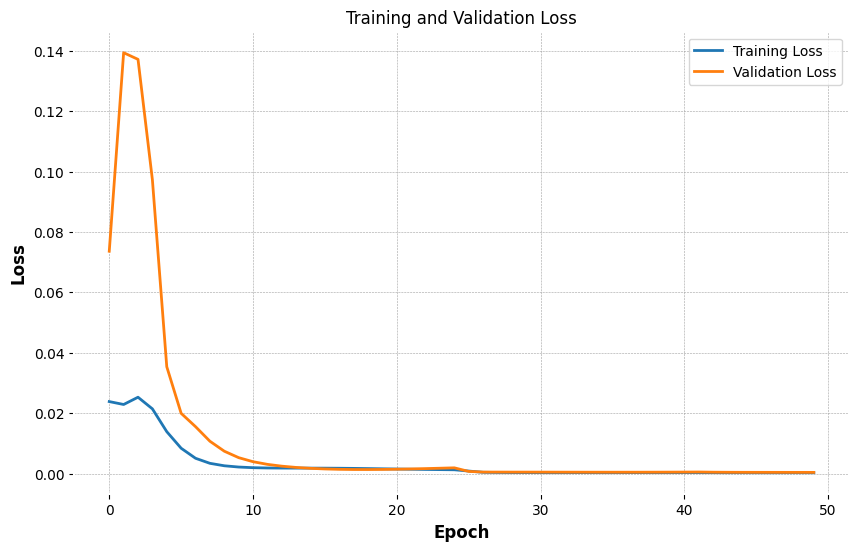

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        progress_bar.set_postfix({'loss': loss.item()})
    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_train_loss)

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses.append(epoch_test_loss)

    scheduler.step(epoch_test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

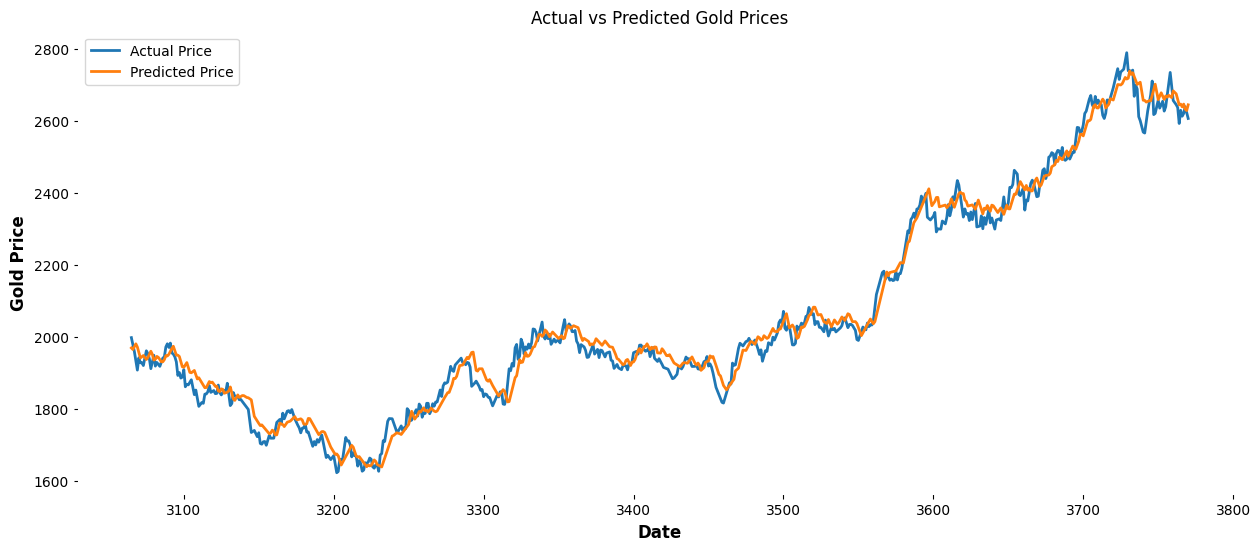

In [ ]:
def inverse_transform(scaler, data, feature_index):
    dummy = np.zeros((len(data), scaler.n_features_in_))
    dummy[:, feature_index] = data.reshape(-1)
    return scaler.inverse_transform(dummy)[:, feature_index]

model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions.extend(outputs.cpu().numpy())
        actuals.extend(labels.cpu().numpy())

predictions = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(predictions), 0)
actuals = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(actuals), 0)

results_df = pd.DataFrame({
    'Date': df.index[-len(actuals):],
    'Actual': actuals,
    'Predicted': predictions
})

plt.figure(figsize=(15, 6))
plt.plot(results_df['Date'], results_df['Actual'], label='Actual Price')
plt.plot(results_df['Date'], results_df['Predicted'], label='Predicted Price')
plt.xlabel('Date')
plt.ylabel('Gold Price')
plt.title('Actual vs Predicted Gold Prices')
plt.legend()
plt.grid()
plt.show()

In [ ]:
df

,Date,Close,High,Low,Open,Volume,Month,WeekOfYear,Close_Pct_Change,Close_Rolling_Mean,...,Close_Lag_30,Daily_Return,Volatility_7D,Volatility_30D,Day_Friday,Day_Monday,Day_Thursday,Day_Tuesday,Day_Wednesday,Target
211,2010-11-01,1350.199951,1360.300049,1350.699951,1360.300049,40,11,44,-0.005084,1331.009993,...,1279.000000,-0.005084,0.009775,0.009672,0.0,1.0,0.0,0.0,0.0,1356.400024
212,2010-11-02,1356.400024,1356.800049,1355.500000,1356.800049,17,11,44,0.004592,1333.809993,...,1272.400024,0.004592,0.009699,0.009592,0.0,0.0,0.0,1.0,0.0,1337.099976
213,2010-11-03,1337.099976,1359.199951,1327.500000,1351.400024,135,11,44,-0.014229,1335.373328,...,1290.199951,-0.014229,0.011108,0.009776,0.0,0.0,0.0,0.0,1.0,1382.699951
214,2010-11-04,1382.699951,1392.500000,1368.599976,1368.599976,109,11,44,0.034104,1338.319991,...,1294.300049,0.034104,0.017030,0.011471,0.0,0.0,1.0,0.0,0.0,1397.300049
215,2010-11-05,1397.300049,1398.000000,1378.199951,1390.699951,109,11,44,0.010559,1341.696659,...,1296.000000,0.010559,0.015409,0.011568,1.0,0.0,0.0,0.0,0.0,1402.800049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3766,2024-12-20,2628.699951,2631.600098,2604.899902,2605.300049,592,12,51,0.014081,2640.229997,...,2698.399902,0.014081,0.010873,0.012384,1.0,0.0,0.0,0.0,0.0,2612.300049
3767,2024-12-23,2612.300049,2627.699951,2611.100098,2620.000000,451,12,52,-0.006239,2637.723332,...,2687.500000,-0.006239,0.009691,0.012411,0.0,1.0,0.0,0.0,0.0,2620.000000
3768,2024-12-24,2620.000000,2620.000000,2609.500000,2613.000000,35,12,52,0.002948,2638.016667,...,2611.199951,0.002948,0.009323,0.011282,0.0,0.0,0.0,1.0,0.0,2638.800049
3769,2024-12-26,2638.800049,2638.800049,2627.899902,2628.500000,84,12,52,0.007176,2639.310002,...,2600.000000,0.007176,0.009939,0.011320,0.0,0.0,1.0,0.0,0.0,2617.199951


In [ ]:
results_df

,Date,Actual,Predicted
0,3065,1998.099999,1969.498595
1,3066,1982.699952,1965.255231
2,3067,1959.599933,1972.847381
3,3068,1928.499989,1980.895365
4,3069,1908.000013,1972.169690
...,...,...,...
701,3766,2612.300094,2638.285194
702,3767,2619.999962,2646.024110
703,3768,2638.800066,2631.776231
704,3769,2617.199916,2627.987769


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(actuals, predictions)
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actuals, predictions)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Mean Squared Error (MSE): {mse:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'R-squared (R2) Score: {r2:.4f}')

percentage_errors = np.abs((actuals - predictions) / actuals) * 100
mean_ape = np.mean(percentage_errors)
print(f'Mean Absolute Percentage Error (MAPE): {mean_ape:.2f}%')

Mean Absolute Error (MAE): 27.48
Mean Squared Error (MSE): 1144.64
Root Mean Squared Error (RMSE): 33.83
R-squared (R2) Score: 0.9868
Mean Absolute Percentage Error (MAPE): 1.35%


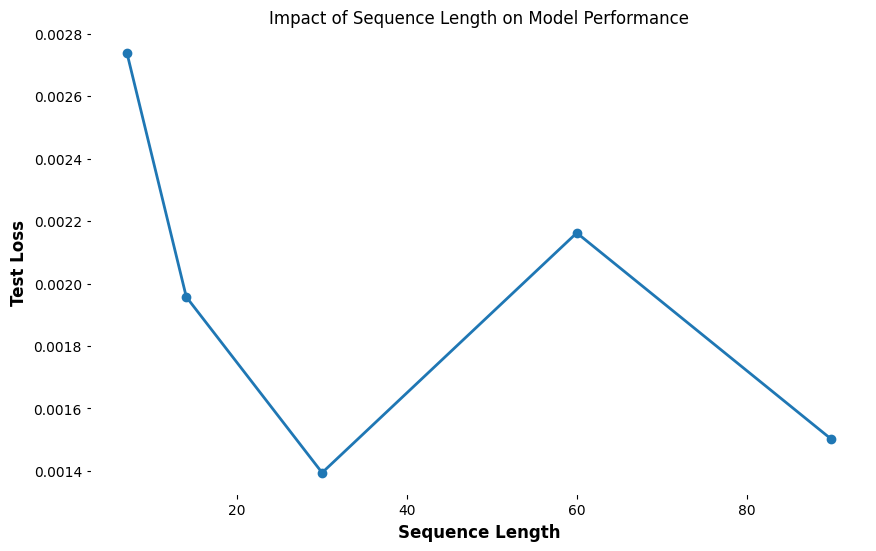

In [ ]:
def evaluate_sequence_length(sequence_lengths):
    results = {}
    for sl in sequence_lengths:
        X, y = create_sequences(scaled_features, scaled_target, sl)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

        train_dataset = GoldPriceDataset(X_train, y_train)
        test_dataset = GoldPriceDataset(X_test, y_test)

        model = GoldPricePredictor(input_size, hidden_size, num_layers, output_size).to(device)

        train_loss, test_loss = train_and_evaluate(model, train_dataset, test_dataset)
        results[sl] = {'train_loss': train_loss, 'test_loss': test_loss}

    return results

def train_and_evaluate(model, train_dataset, test_dataset, epochs=20):
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    model.eval()
    with torch.no_grad():
        train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            train_loss += criterion(outputs, labels).item()

        test_loss = 0
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            test_loss += criterion(outputs, labels).item()

    return train_loss/len(train_loader), test_loss/len(test_loader)

sequence_lengths = [7, 14, 30, 60, 90]
results = evaluate_sequence_length(sequence_lengths)

plt.figure(figsize=(10, 6))
plt.plot(list(results.keys()), [r['test_loss'] for r in results.values()], marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Test Loss')
plt.title('Impact of Sequence Length on Model Performance')
plt.grid()
plt.show()

In [ ]:
class GoldPricePredictorWithDropout(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_prob=0.2):
        super(GoldPricePredictorWithDropout, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_prob)
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.dropout(out[:, -1, :])  # Apply dropout to the last time step's output
        out = self.fc(out)
        return out

model_dropout = GoldPricePredictorWithDropout(input_size, hidden_size, num_layers, output_size).to(device)
print(model_dropout)

GoldPricePredictorWithDropout(
  (lstm): LSTM(13, 128, num_layers=2, batch_first=True, dropout=0.2)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_dropout = GoldPricePredictorWithDropout(
    input_size=len(feature_columns),
    hidden_size=128,
    num_layers=2,
    output_size=1,
    dropout_prob=0.3
).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_dropout.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

num_epochs = 50
train_losses_dropout = []
test_losses_dropout = []

Epoch 1/50, Train Loss: 0.028576, Test Loss: 0.105328
Epoch 2/50, Train Loss: 0.023950, Test Loss: 0.150861
Epoch 3/50, Train Loss: 0.024698, Test Loss: 0.127538
Epoch 4/50, Train Loss: 0.018216, Test Loss: 0.044670
Epoch 5/50, Train Loss: 0.011582, Test Loss: 0.039607
Epoch 6/50, Train Loss: 0.005841, Test Loss: 0.011013
Epoch 7/50, Train Loss: 0.005247, Test Loss: 0.014988
Epoch 8/50, Train Loss: 0.003838, Test Loss: 0.009472
Epoch 9/50, Train Loss: 0.003180, Test Loss: 0.007108
Epoch 10/50, Train Loss: 0.002840, Test Loss: 0.005141
Epoch 11/50, Train Loss: 0.002540, Test Loss: 0.003845
Epoch 12/50, Train Loss: 0.002580, Test Loss: 0.003250
Epoch 13/50, Train Loss: 0.002413, Test Loss: 0.002554
Epoch 14/50, Train Loss: 0.002209, Test Loss: 0.001913
Epoch 15/50, Train Loss: 0.002422, Test Loss: 0.001650
Epoch 16/50, Train Loss: 0.002464, Test Loss: 0.001363
Epoch 17/50, Train Loss: 0.002261, Test Loss: 0.001149
Epoch 18/50, Train Loss: 0.001940, Test Loss: 0.001146
Epoch 19/50, Train 

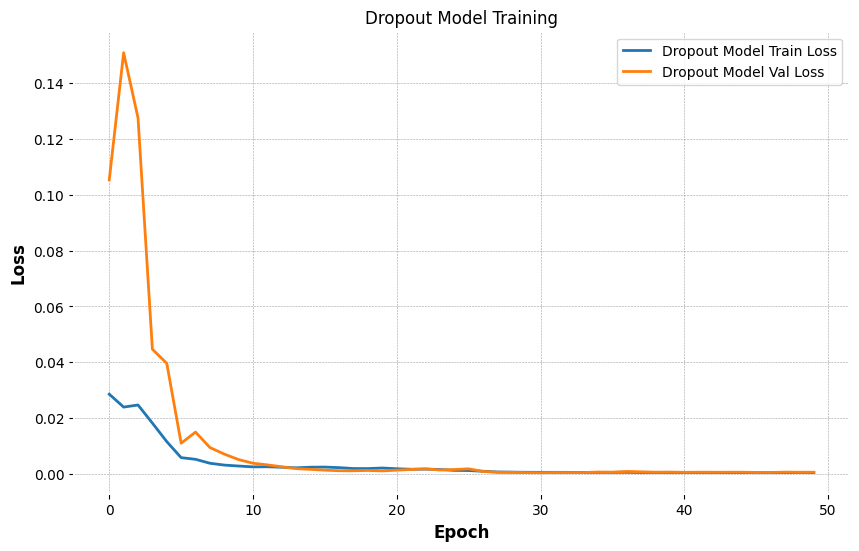

In [ ]:
for epoch in range(num_epochs):
    model_dropout.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_dropout(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    train_losses_dropout.append(epoch_train_loss)

    model_dropout.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model_dropout(inputs)
            test_loss += criterion(outputs, labels).item() * inputs.size(0)

    epoch_test_loss = test_loss / len(test_loader.dataset)
    test_losses_dropout.append(epoch_test_loss)
    scheduler.step(epoch_test_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss:.6f}, Test Loss: {epoch_test_loss:.6f}')

plt.figure(figsize=(10, 6))
plt.plot(train_losses_dropout, label='Dropout Model Train Loss')
plt.plot(test_losses_dropout, label='Dropout Model Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Dropout Model Training')
plt.show()

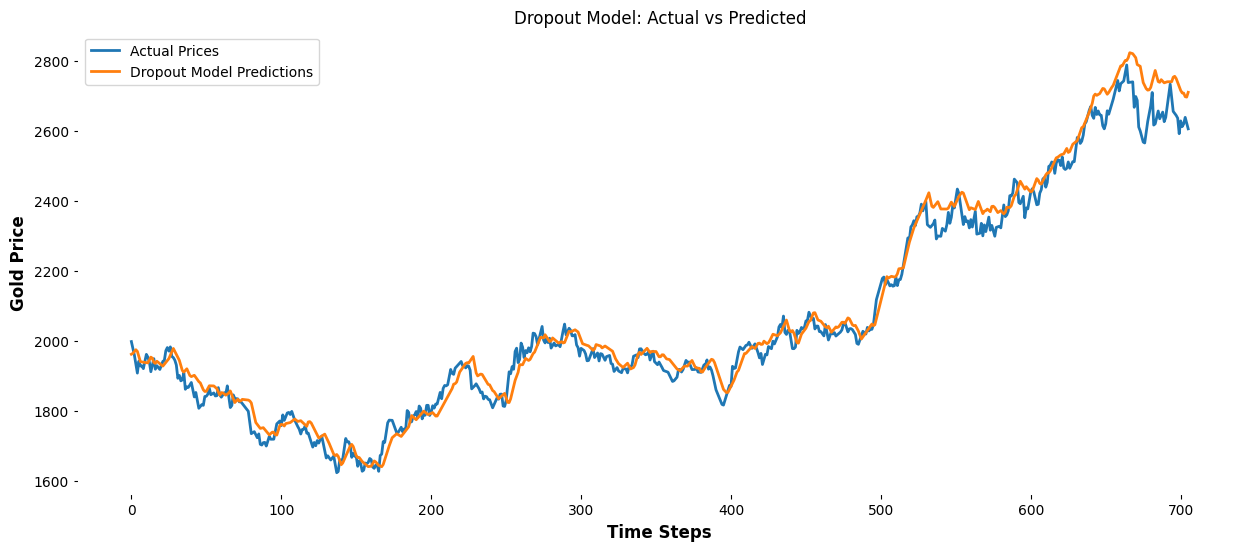

Dropout Model Metrics:
MAE: 32.82
RMSE: 43.28
R2: 0.9783


In [ ]:
model_dropout.eval()
predictions_dropout, actuals_dropout = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_dropout(inputs)

        predictions_dropout.extend(outputs.cpu().numpy())
        actuals_dropout.extend(labels.cpu().numpy())

predictions_dropout = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(predictions_dropout), 0)
actuals_dropout = inverse_transform(MinMaxScaler().fit(df[['Target']]), np.array(actuals_dropout), 0)

plt.figure(figsize=(15, 6))
plt.plot(actuals_dropout, label='Actual Prices')
plt.plot(predictions_dropout, label='Dropout Model Predictions')
plt.title('Dropout Model: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Gold Price')
plt.legend()
plt.grid()
plt.show()

mae_dropout = mean_absolute_error(actuals_dropout, predictions_dropout)
rmse_dropout = np.sqrt(mean_squared_error(actuals_dropout, predictions_dropout))
r2_dropout = r2_score(actuals_dropout, predictions_dropout)

print(f'Dropout Model Metrics:')
print(f'MAE: {mae_dropout:.2f}')
print(f'RMSE: {rmse_dropout:.2f}')
print(f'R2: {r2_dropout:.4f}')